In [1]:
from scipy.stats import laplace
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

## Importa o dataset

In [2]:
dataset = pd.read_csv("adult.csv")
dataset.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native-country,class
0,2,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,1,0,2,United-States,<=50K
1,3,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,0,United-States,<=50K
2,2,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,2,United-States,<=50K
3,3,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,2,United-States,<=50K
4,1,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,2,Cuba,<=50K


## Consultas

* Q1: Média do atributo age
* Q2: Somatório do atributo capital-gain
* Q3: Média do atributo hours-per-week
* Q4: Quantidade de pessoas com income > 50K

In [3]:
def Q1(dataset):
    return dataset.age.mean()

def Q2(dataset):
    return dataset.capitalgain.sum()

def Q3(dataset):
    return dataset.hoursperweek.mean()

def Q4(dataset):
    DatasetProcessado = dataset[dataset["class"] == ">50K"]
    return DatasetProcessado.shape[0]


## Vizinhança


In [4]:
def gerarVizinho(dataset,linhaRemover):
    return dataset.drop([linhaRemover])

def gerarListaVizinhosOtimizado(dataset, f):
    naoMudar = NaoMudar(f)
    unicos = []
    listaTodosVizinhos = []
    for i in range(dataset.shape[0]):
        if(dataset.iloc[i][naoMudar] not in unicos):
            unicos.append(dataset.iloc[i][naoMudar])
            listaTodosVizinhos.append(gerarVizinho(dataset, i))
    return listaTodosVizinhos

In [5]:
def NaoMudar(f):
    if(f==Q1):
        return "age"
    if(f==Q2):
        return "capitalgain"
    if(f==Q3):
        return "hoursperweek"
    if(f==Q4):
        return "capitalgain"

## Sensibilidade

In [6]:
def calcularSensibilidade(dataset, f, sensibilidadeDatasetOriginal):   
    maiorDiferenca = 0
        
    for vizinho in gerarListaVizinhosOtimizado(dataset, f):
        diferenca = abs(sensibilidadeDatasetOriginal - f(vizinho))
        if maiorDiferenca < diferenca:
            maiorDiferenca = diferenca
            
    return maiorDiferenca

## Laplace

In [7]:
def calcularRuido(delta, budget, u):
    return laplace.rvs(loc=u, scale=delta/budget)

## Apresenta Laplace

In [34]:
def apresentarDistribuicao(budget, u, sensibilidade, consulta):
    fig, ax = plt.subplots()
 
    r = laplace.rvs(loc=u, scale=sensibilidade/budget, size=1000)
    ax.hist(r, density=True, histtype='stepfilled', alpha=0.2)  
   
    plt.xlabel('x')
    plt.ylabel('laplace')
    plt.title('Budget = {} - Consulta {}'.format(budget, consulta))

    plt.show()

## Mecanismo

In [14]:
def calcularResposta(dataset, funcoes, budgets, u):
    resultados = []
    sensibilidades = []
    
    for budget in budgets:
        indiceFuncao = 1
        
        for funcao in funcoes:
            sensibilidadeDatasetOriginal = funcao(dataset)
            delta = calcularSensibilidade(dataset, funcao, sensibilidadeDatasetOriginal)
            
            ruido = calcularRuido(delta, budget/len(funcoes), u)
            
            fD = funcao(dataset)
            resultado = fD + ruido
            
            apresentarDistribuicao(budget, u, delta, 'Q'+str(indiceFuncao))
            
            print('Budget: {}'.format(budget))
            print('Função: Q{}'.format(indiceFuncao))
            print('Sensibilidade: {}'.format(delta))
            print('F(D): {}'.format(fD))
            print('Ruído: {}'.format(ruido))
            print('Ruído + F(D): {}'.format(resultado))
            print('')
            
            indiceFuncao += 1
            
            sensibilidades.append(delta)
            resultados.append(resultado)
    
    consultas = ['Q1', 'Q2', 'Q3', 'Q4']

    return (budgets, consultas, sensibilidades, resultados)

## Salvando o resultado

In [10]:
def salvarResultados(resultadosLaplace):
    budgets = resultadosLaplace[0]
    consultas = resultadosLaplace[1]
    sensibilidades = resultadosLaplace[2]
    resultados = resultadosLaplace[3]
    resultadoLista = []

    indiceSensibilidade = 0
    for budget in budgets:
        for consulta in consultas:
            resultadoLista.append([budget, consulta, sensibilidades[indiceSensibilidade], resultados[indiceSensibilidade]])
            indiceSensibilidade += 1
    
    resultadoDataframe = pd.DataFrame(resultadoLista, columns=['budget', 'consulta', 'sensibilidade', 'resultado'])
    resultadoDataframe.to_csv('resultado.csv', index=False)
    return resultadoDataframe

In [15]:
def main():
    budgets = [0.1, 1, 10]
    funcoes = [Q1, Q2, Q3, Q4]
    u = 0
    resultados = calcularResposta(dataset, funcoes, budgets, u)
    salvarResultados(resultados)

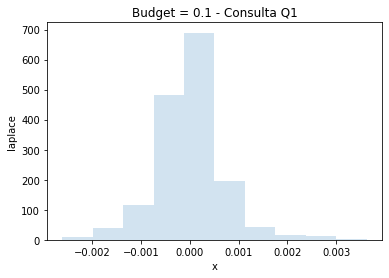

Budget: 0.1
Função: Q1
Sensibilidade: 4.5636285693984036e-05
F(D): 1.7710781704270915
Ruído: -0.0021594863669413874
Ruído + F(D): 1.76891868406015



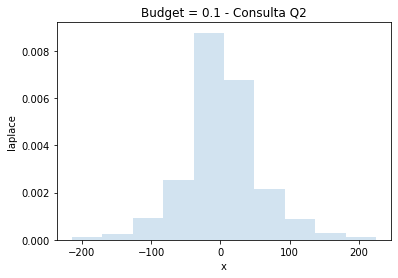

Budget: 0.1
Função: Q2
Sensibilidade: 4
F(D): 9784
Ruído: 363.75667234284714
Ruído + F(D): 10147.756672342846



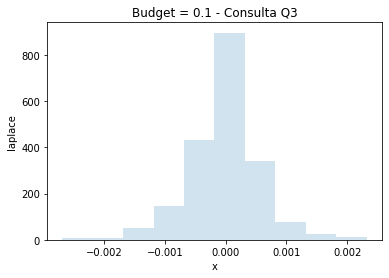

Budget: 0.1
Função: Q3
Sensibilidade: 4.19586378328507e-05
F(D): 1.9506981696081243
Ruído: -0.0003271141313585312
Ruído + F(D): 1.9503710554767657



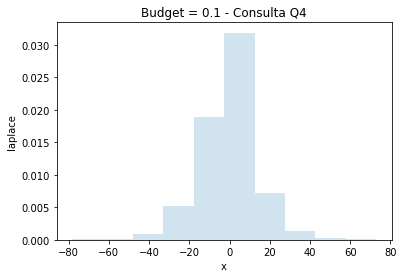

Budget: 0.1
Função: Q4
Sensibilidade: 1
F(D): 11687
Ruído: 56.31676438226136
Ruído + F(D): 11743.316764382262



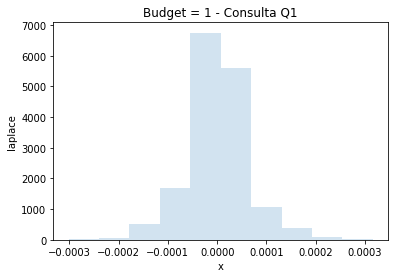

Budget: 1
Função: Q1
Sensibilidade: 4.5636285693984036e-05
F(D): 1.7710781704270915
Ruído: 5.5341497535199676e-05
Ruído + F(D): 1.7711335119246268



In [ ]:
main()